# Evaluating & Checking Process for finding an optimal fraction of the best featurs for training the Binary ML model.

In [1]:
import pandas as pd
import numpy as np
import time
import copy
import itertools
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
print("✅ All required libraries successfully imported.")


✅ All required libraries successfully imported.


In [2]:
# THIS PART CHANGES WITH DIFFERENT DATASETS:
datasets = {
    'us_crime': "https://archive.ics.uci.edu/static/public/183/data.csv",
    'libras_move': "/content/movement_libras.data", # dataset is on the local machine. (downloaded and unzipped from https://archive.ics.uci.edu/static/public/181/libras+movement.zip)
    'letter_img': "https://archive.ics.uci.edu/static/public/59/data.csv",
    'mammography': "https://archive.ics.uci.edu/static/public/161/data.csv"
}

data_dict = {}
for name, url in datasets.items():
    data = pd.read_csv(url, header=None)

    if name == 'us_crime':
        data = data.drop(columns=[3])
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].astype(float).apply(lambda x: 1 if x > 0.65 else 0).astype(int)  # Target is the last column
        print(f'dataset {name}: Target: > 0.65 (1) or < 0.65 (0).')
    elif name == 'libras_move':
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].apply(lambda x: 1 if x == 1 else 0).astype(int)  # Target is the last column
        print(f'dataset {name}: Target: 1 or others (0).')
    elif name == 'letter_img':
        X = data.iloc[1:, 1:]  # Features start from the second column
        y = data.iloc[1:, 0].apply(lambda x: 1 if x == 'Z' else 0).astype(int)  # Target is the first column
        print(f'dataset {name}: Target: "Z" or others (0).')
    elif name == 'mammography':
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].astype(int)  # Target is the last column
        print(f'dataset {name}: Target: 1 (1= Malignant) or 0 (0= Benign).')

    data_dict[name] = (X, y)


dataset us_crime: Target: > 0.65 (1) or < 0.65 (0).
dataset libras_move: Target: 1 or others (0).
dataset letter_img: Target: "Z" or others (0).
dataset mammography: Target: 1 (1= Malignant) or 0 (0= Benign).


In [3]:
def calculate_f1_scores_multiple_splits(X_scaled, y, num_splits= 5): # POINT: MORE num_splits FOR MORE ACCURATE RESULTS (real features ranking).
    start_time = time.time()  # Record start time
    # multiple splits (tests) for having a more reliable and accurate evaluating features because of the random state problem.
    f1_scores = []
    for _ in range(num_splits):
      random_state = np.random.randint(100) # Generate a random seed
      for i in range(X_scaled.shape[1]):
          X_feature = X_scaled.iloc[:, i].values.reshape(-1, 1)

          # Convert '?' to NaN and then impute missing values
          X_feature = np.where(X_feature == '?', np.nan, X_feature)
          imputer = SimpleImputer(strategy='median') # Or another suitable strategy
          X_feature = imputer.fit_transform(X_feature)

          X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.25, random_state= random_state)
          # random_state for having the mix of examples.


          clf = DecisionTreeClassifier()
          clf.fit(X_train, y_train)
          y_pred = clf.predict(X_test)

          average = 'binary'
          f1 = f1_score(y_test, y_pred, average= average)
          f1_scores.append(f1)

    end_time = time.time()  # Record end time
    execution_time = end_time - start_time  # Calculate execution time

    return np.array(f1_scores).reshape(num_splits, -1), execution_time/ num_splits # Reshape for easy averaging and returning time


In [4]:
# FEEL FREE TO EXPERIMENT WITH DIFFERENT ML ALGORITHMS HERE.
def evaluate_svm_with_selected_features_multiple_splits(X_scaled, y, feature_ranking, fractions, num_splits= 5, scaler=None): # POINT: MORE num_splits FOR MORE ACCURATE RESULTS (real outcomes of fractions).
    results_all= []
    for _ in range(num_splits):
      random_state= np.random.randint(100)
      results = {'fraction': [], 'f1_score': [], 'precision': [], 'recall': []}
      for fraction in fractions:
          num_features = max(1, int(fraction * X_scaled.shape[1])) # ensure that at least one feature is selected.
          selected_features = feature_ranking[:num_features]
          X_selected = X_scaled.iloc[:, selected_features]

          # Convert '?' to NaN and then impute missing values
          X_selected = np.where(X_selected == '?', np.nan, X_selected)
          imputer = SimpleImputer(strategy='median') # median is better than mean (maybe because of the outlier data in datasets.)
          X_selected = imputer.fit_transform(X_selected)

          X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state= random_state)

          X_train = scaler.fit_transform(X_train)
          X_test = scaler.transform(X_test)

          svm = SVC(kernel='rbf', class_weight= 'balanced')
          svm.fit(X_train, y_train)
          y_pred = svm.predict(X_test)

          average = 'binary'
          f1 = f1_score(y_test, y_pred, average= average)
          precision = precision_score(y_test, y_pred, average= average)
          recall = recall_score(y_test, y_pred, average= average)

          results['fraction'].append(fraction)
          results['f1_score'].append(f1)
          results['precision'].append(precision)
          results['recall'].append(recall)
      results_all.append(results)
    return results_all


Evaluating dataset: us_crime
  X shape: (1994, 126)
  y shape: (1994,)
  Majority-Minority Class Ratio: 12:1
Feature evaluation for us_crime, took 2.46 seconds.
Average time per feature: 0.0195 seconds.


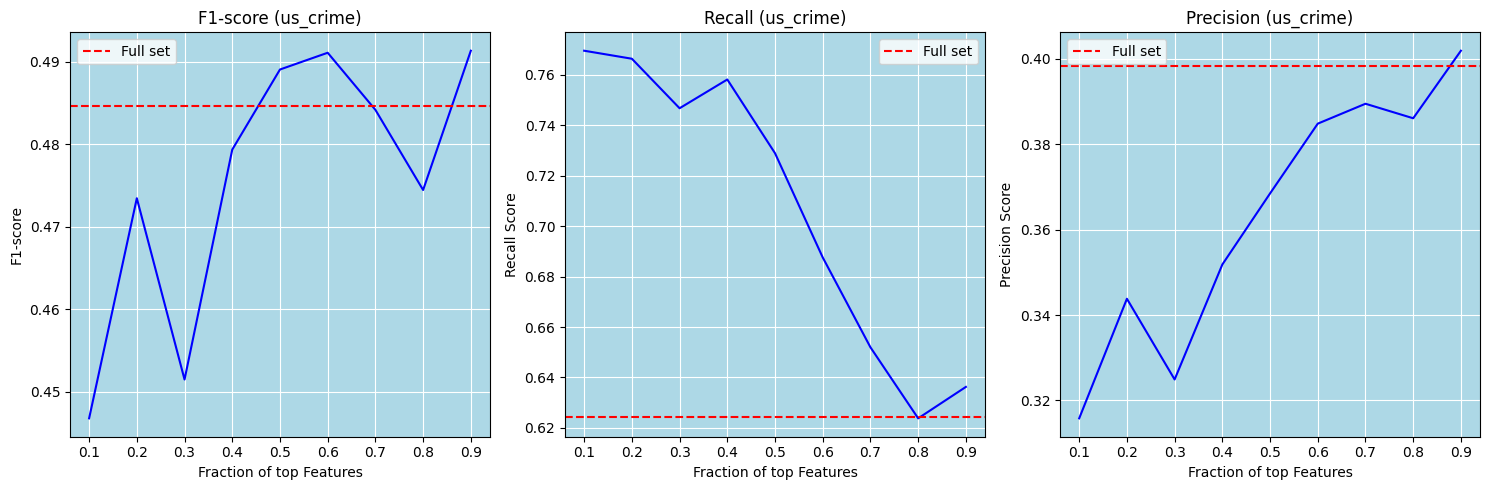

The best fraction of top features in this problem based on the F1-score is 0.9 with F1-score of 0.491336.
Therefore we can use the 0.9 fraction of top features as an optima.
Features (from highest to lowest score) as an optimal subset:
Feature: #feature_name:#feature_location, F1-score based Rank: #rank, F1-score: #f1_score_value
Feature: PctKids2Par:49, F1-score based Rank: 1, F1-score: 0.395965
Feature: PctTeen2Par:51, F1-score based Rank: 2, F1-score: 0.345665
Feature: PctIlleg:55, F1-score based Rank: 3, F1-score: 0.341169
Feature: PctFam2Par:48, F1-score based Rank: 4, F1-score: 0.339853
Feature: PctYoungKids2Par:50, F1-score based Rank: 5, F1-score: 0.287213
Feature: NumIlleg:54, F1-score based Rank: 6, F1-score: 0.274997
Feature: racePctWhite:8, F1-score based Rank: 7, F1-score: 0.269150
Feature: PctPolicBlack:111, F1-score based Rank: 8, F1-score: 0.266568
Feature: PctPolicWhite:110, F1-score based Rank: 9, F1-score: 0.245330
Feature: RacialMatchCommPol:109, F1-score based Rank

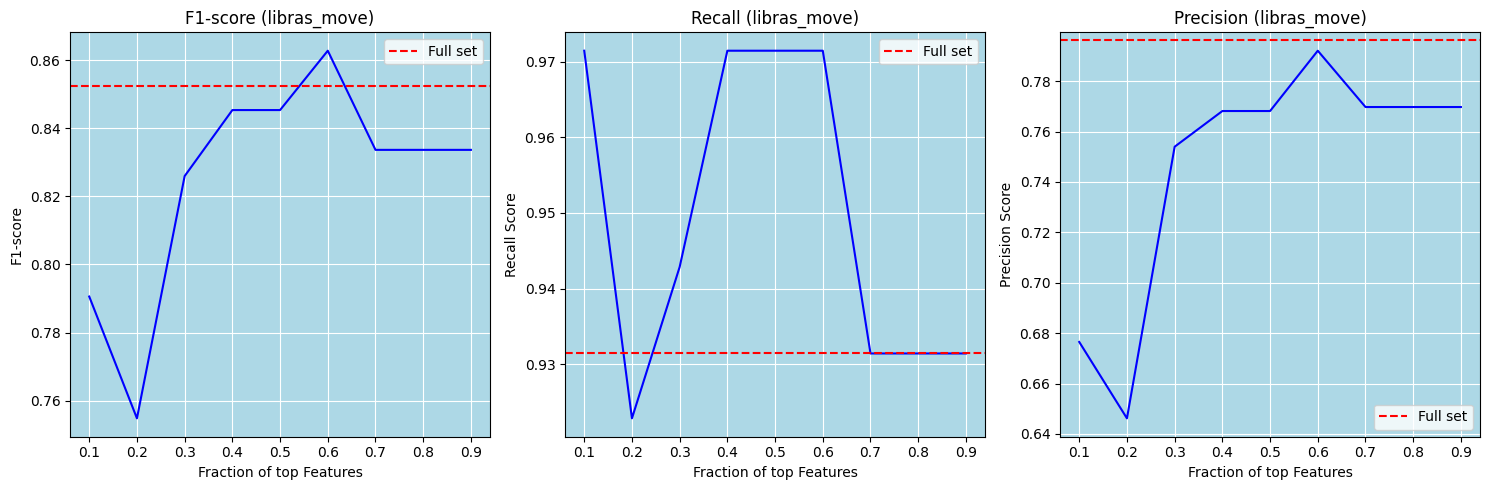

The best fraction of top features in this problem based on the F1-score is 0.6 with F1-score of 0.862771.
Therefore we can use the 0.6 fraction of top features as an optima.
Features (from highest to lowest score) as an optimal subset:
Feature: #feature_name:#feature_location, F1-score based Rank: #rank, F1-score: #f1_score_value
Feature: 50:50, F1-score based Rank: 1, F1-score: 0.458730
Feature: 28:28, F1-score based Rank: 2, F1-score: 0.391919
Feature: 54:54, F1-score based Rank: 3, F1-score: 0.350476
Feature: 48:48, F1-score based Rank: 4, F1-score: 0.347727
Feature: 31:31, F1-score based Rank: 5, F1-score: 0.312698
Feature: 10:10, F1-score based Rank: 6, F1-score: 0.236032
Feature: 26:26, F1-score based Rank: 7, F1-score: 0.213810
Feature: 47:47, F1-score based Rank: 8, F1-score: 0.205556
Feature: 71:71, F1-score based Rank: 9, F1-score: 0.180466
Feature: 32:32, F1-score based Rank: 10, F1-score: 0.175824
Feature: 12:12, F1-score based Rank: 11, F1-score: 0.169697
Feature: 70:70, F

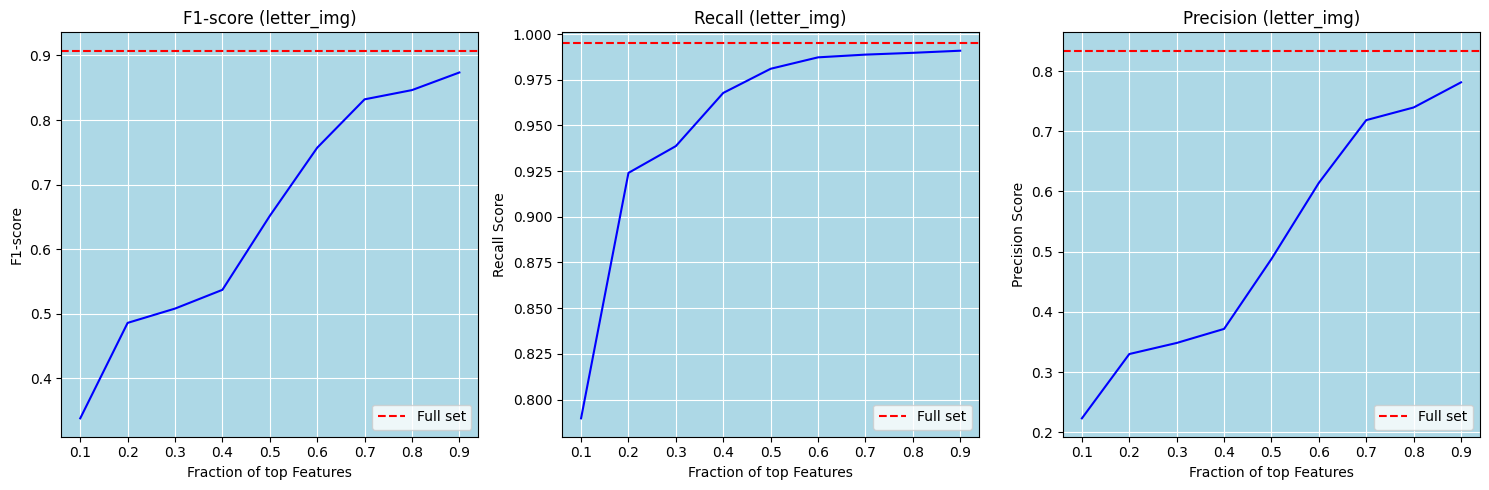

The best fraction of top features in this problem based on the F1-score is 1.0 with F1-score of 0.907399.
Therefore we can use the 1.0 fraction of top features as an optima.
Features (from highest to lowest score) as an optimal subset:
Feature: #feature_name:#feature_location, F1-score based Rank: #rank, F1-score: #f1_score_value
Feature: y2bar:9, F1-score based Rank: 1, F1-score: 0.328658
Feature: high:4, F1-score based Rank: 2, F1-score: 0.006429
Feature: y-ege:15, F1-score based Rank: 3, F1-score: 0.004434
Feature: yegvx:16, F1-score based Rank: 4, F1-score: 0.000000
Feature: xegvy:14, F1-score based Rank: 5, F1-score: 0.000000
Feature: x-ege:13, F1-score based Rank: 6, F1-score: 0.000000
Feature: xy2br:12, F1-score based Rank: 7, F1-score: 0.000000
Feature: x2ybr:11, F1-score based Rank: 8, F1-score: 0.000000
Feature: xybar:10, F1-score based Rank: 9, F1-score: 0.000000
Feature: x2bar:8, F1-score based Rank: 10, F1-score: 0.000000
Feature: y-bar:7, F1-score based Rank: 11, F1-score

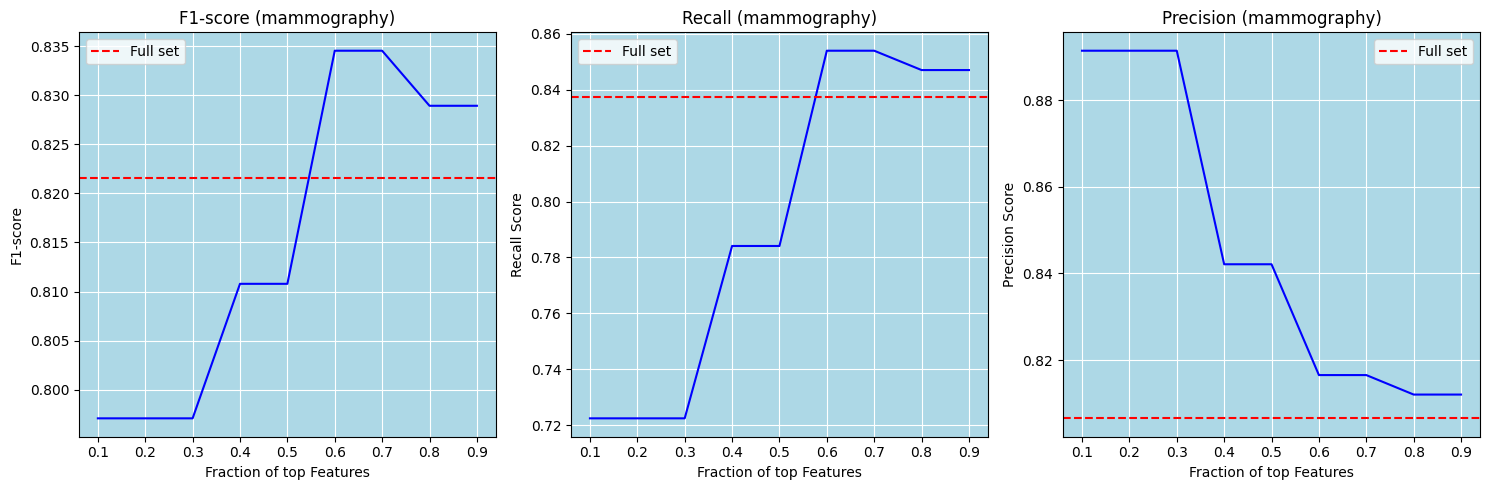

The best fraction of top features in this problem based on the F1-score is 0.6 with F1-score of 0.834527.
Therefore we can use the 0.6 fraction of top features as an optima.
Features (from highest to lowest score) as an optimal subset:
Feature: #feature_name:#feature_location, F1-score based Rank: #rank, F1-score: #f1_score_value
Feature: BI-RADS:0, F1-score based Rank: 1, F1-score: 0.766138
Feature: Margin:3, F1-score based Rank: 2, F1-score: 0.751466
Feature: Shape:2, F1-score based Rank: 3, F1-score: 0.746336
Saved dataset with optimal feature set for mammography to mammography_optimal.csv
************************************************** 



In [5]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # POINT: MORE FRACTIONS FOR MORE ACCURATE RESULTS (real number of features).
# these three following lists are for the last summary metric section.
optimal_fractions= []
optimal_f1_scores= []

full_set_f1_scores= []
_010_f1_scores= [] # F1-scores of 0.1 fraction of top features for all datasets. # OPTIONAL

# these are for implementing the new ideas:
num_optimal_features_all_datasets= []
feature_ranking_all_datasets= []
scalers= {}

all_datasets_all_fractions_f1_scores= []

for name, (X, y) in data_dict.items():
    print(f"Evaluating dataset: {name}")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")
    unique, counts = np.unique(y, return_counts=True)
    ratio = int(counts[np.argmax(counts)] / counts[np.argmin(counts)])
    print(f"  Majority-Minority Class Ratio: {ratio}:1")
    # print("\n")

    # Imputing before scaling:
    # Convert '?' to NaN and then impute missing values
    X_imputed = np.where(X == '?', np.nan, X)
    imputer = SimpleImputer(strategy='median') # Or another suitable strategy
    X_imputed = imputer.fit_transform(X_imputed)
    X_imputed = pd.DataFrame(X_imputed, columns=X.columns)  # Convert back to DataFrame

    # Scale features for every dataset:
    # ensures that features are scaled only once per dataset, before feature selection.
    scaler = StandardScaler()
    scalers[name]= scaler

    X_scaled = scaler.fit_transform(X_imputed)
    X_scaled = pd.DataFrame(X_scaled, columns=X_imputed.columns)  # Convert back to DataFrame

    f1_scores_multiple, eval_duration = calculate_f1_scores_multiple_splits(X_scaled, y)

    features_f1_scores= f1_scores_multiple.mean(axis=0) # Average across rows (splits)
    print(f"Feature evaluation for {name}, took {eval_duration:.2f} seconds.")  # Display all features evaluation execution time.
    print(f"Average time per feature: {eval_duration/ X_scaled.shape[1]:.4f} seconds.")  # Display average feature time.

    feature_ranking = np.argsort(features_f1_scores)[::-1] # Rank features based on their F1-scores and the variable contains indices of the features sorted by their F1-scores from highest to lowest.

    # Evaluate SVM classifier with selected features
    results_multiple = evaluate_svm_with_selected_features_multiple_splits(X_scaled, y, feature_ranking, fractions, scaler=scaler)

    # Calculate average scores for each fraction:
    average_f1_scores = []
    average_precision_scores = []
    average_recall_scores = []

    for fraction in fractions:
        f1_scores_for_fraction = [result['f1_score'][fractions.index(fraction)] for result in results_multiple]
        precision_scores_for_fraction = [result['precision'][fractions.index(fraction)] for result in results_multiple]
        recall_scores_for_fraction = [result['recall'][fractions.index(fraction)] for result in results_multiple]

        average_f1_scores.append(np.mean(f1_scores_for_fraction))
        average_precision_scores.append(np.mean(precision_scores_for_fraction))
        average_recall_scores.append(np.mean(recall_scores_for_fraction))

    # Now we have average scores for each fraction across multiple splits
    # We use these average scores for plotting instead of the single-split scores
    f1_scores = copy.deepcopy(average_f1_scores)
    recall_scores = copy.deepcopy(average_recall_scores)
    precision_scores = copy.deepcopy(average_precision_scores)

    # having the f1_scores of all dataset based on the fractions for later comparison
    all_datasets_all_fractions_f1_scores.append(f1_scores)

    # Plotting:
    plt.figure(figsize=(15, 5))

    # Plot F1-score:
    plt.subplot(1, 3, 1)
    plt.plot(fractions[: -1], f1_scores[: -1], color= "blue")
    plt.axhline(y= f1_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'F1-score ({name})')
    plt.xlabel('Fraction of top Features')
    plt.ylabel('F1-score')
    plt.grid(True, color='white')
    plt.gca().set_facecolor('lightblue')
    plt.grid(True)
    plt.legend()

    # Plot Recall score
    plt.subplot(1, 3, 2)
    plt.plot(fractions[: -1], recall_scores[: -1], color= "blue")
    plt.axhline(y= recall_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'Recall ({name})')
    plt.xlabel('Fraction of top Features')
    plt.ylabel('Recall Score')
    plt.grid(True, color='white')
    plt.gca().set_facecolor('lightblue')
    plt.grid(True)
    plt.legend()

    # Plot Precision score
    plt.subplot(1, 3, 3)
    plt.plot(fractions[: -1], precision_scores[: -1], color= "blue")
    plt.axhline(y= precision_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'Precision ({name})')
    plt.xlabel('Fraction of top Features')
    plt.ylabel('Precision Score')
    plt.grid(True, color='white')  # White grid lines
    plt.gca().set_facecolor('lightblue')  # Light blue background
    plt.grid(True)

    plt.tight_layout()
    plt.legend()
    plt.show()

    optimal_f1_score= max(f1_scores) # related to the optimal fraciton of all fractions.
    optimal_fraction= fractions[f1_scores.index(optimal_f1_score)] # The f1_scores list corresponds directly to the fractions list, with each score representing the F1-score for the respective fraction of top features.
    # TIP: The index() method prioritizes lower indices, so if a value appears multiple times, the optimal fraction will be determined by the earliest occurrence.
    print(f"The best fraction of top features in this problem based on the F1-score is {optimal_fraction} with F1-score of {optimal_f1_score:.6f}.")
    print(f"Therefore we can use the {optimal_fraction} fraction of top features as an optima.")

    # for summary metric section:
    optimal_fractions.append(optimal_fraction)
    optimal_f1_scores.append(optimal_f1_score)
    full_set_f1_scores.append(f1_scores[-1])
    _010_f1_scores.append(f1_scores[0]) # OPTIONAL
    num_optimal_features = max(1, int(optimal_fraction * X_scaled.shape[1]))
    num_optimal_features_all_datasets.append(num_optimal_features)
    feature_ranking_all_datasets.append(feature_ranking)

    optimal_feature_indices = feature_ranking[:num_optimal_features] # of optimal fraction.
    print(f"Features (from highest to lowest score) as an optimal subset:")

    ######## # THIS PART CHANGES WITH DIFFERENT DATASETS:
    # having the names of features (again)!
    datasets = {
    'us_crime': "https://archive.ics.uci.edu/static/public/183/data.csv",
    'libras_move': "/content/movement_libras.data", # dataset is on the local machine. (downloaded and unzipped from https://archive.ics.uci.edu/static/public/181/libras+movement.zip)
    'letter_img': "https://archive.ics.uci.edu/static/public/59/data.csv",
    'mammography': "https://archive.ics.uci.edu/static/public/161/data.csv"
    }
    data_reimport = pd.read_csv(datasets[name], header=0)
    if name == 'us_crime':
        data_reimport = data_reimport.drop(columns=['communityname']) #dropping string value feature
        X_reimport = data_reimport.iloc[1:, :-1] # 1: confident starting row.
    elif name == 'libras_move':
        data_reimport = pd.read_csv(datasets[name], header= None) # No header in the dataset.
        X_reimport = data_reimport.iloc[1:, :-1]
    elif name == 'letter_img':
        X_reimport = data_reimport.iloc[1:, 1:]  # Features start from the second column
    elif name == 'mammography':
        X_reimport = data_reimport.iloc[1:, :-1]

    ########

    print("Feature: #feature_name:#feature_location, F1-score based Rank: #rank, F1-score: #f1_score_value")
    for index in optimal_feature_indices:
        feature_loc = X_scaled.columns[index]
        feature_name= X_reimport.columns[index]
        rank = np.where(feature_ranking == index)[0][0] + 1 # Calculate rank in the sorted feature_ranking list (1-based)
        f1_score_value = features_f1_scores[index]  # Get feature F1-score (f1_scores is 0-based)
        print(f"Feature: {feature_name}:{feature_loc}, F1-score based Rank: {rank}, F1-score: {f1_score_value:.6f}")

    # Saving the new csv file for future training and testing with features modified:
    X_optimal = X_reimport.iloc[:, optimal_feature_indices]
    # X_optimal = np.where(X_optimal == '?', np.nan, X_optimal)
    # imputer = SimpleImputer(strategy='median') # the same as what is done in the process.
    # X_optimal = imputer.fit_transform(X_optimal) # it should convert back to a Pandas DataFrame.
    y_new = y.rename("Target")  # Rename the target column from a numerical value.

    optimal_df = pd.concat([X_optimal, y_new], axis=1)  # Combine features and target
    optimal_df.to_csv(f"{name}_optimal_f1_{optimal_f1_score:.4f}.csv", index=False)  # Save to CSV
    print(f"Saved dataset with optimal feature set for {name} to {name}_optimal.csv")

    print(50* '*', '\n')


This shows us that we do not necessarily need to use all the features and also more than one induvidual feature lead to a good ML model.

## **Summary Metric:**

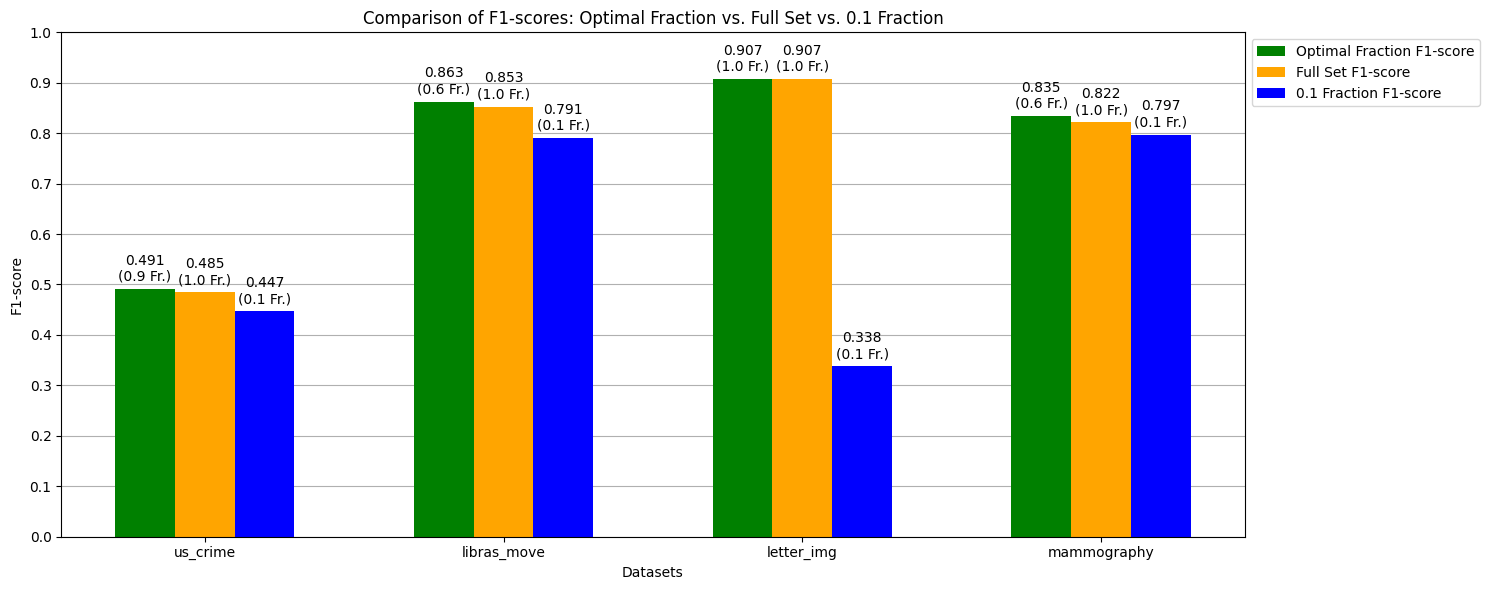

In [6]:
# Summary metrics of optimal fractions of top features vs. full set of features.

dataset_names = list(data_dict.keys())
bar_width = 0.20
index = np.arange(len(dataset_names))

plt.figure(figsize=(15, 6))
plt.bar(index, optimal_f1_scores, bar_width, label='Optimal Fraction F1-score', zorder= 2, color= 'green')
plt.bar(index + bar_width, full_set_f1_scores, bar_width, label='Full Set F1-score', zorder= 2, color= 'orange')
plt.bar(index + 2* bar_width, _010_f1_scores, bar_width, label='0.1 Fraction F1-score', zorder= 2, color= 'blue') # OPTIONAL

plt.xlabel('Datasets')
plt.ylabel('F1-score')
plt.title('Comparison of F1-scores: Optimal Fraction vs. Full Set vs. 0.1 Fraction')
plt.xticks(index + (3* bar_width / 3), dataset_names) # RELATED TO THE OPTIONAL PART.
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
plt.tight_layout()
for i in index:
  plt.text(index[i], optimal_f1_scores[i] + 0.01, f"{optimal_f1_scores[i]:.3f}\n({optimal_fractions[i]} Fr.)", ha='center', va='bottom')
  plt.text(index[i] + bar_width, full_set_f1_scores[i] + 0.01, f"{full_set_f1_scores[i]:.3f}\n(1.0 Fr.)", ha='center', va='bottom')
  plt.text(index[i] + 2* bar_width, _010_f1_scores[i] + 0.01, f"{_010_f1_scores[i]:.3f}\n(0.1 Fr.)", ha='center', va='bottom') # OPTIONAL

plt.yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks with a step of 0.1
plt.grid(True, axis= 'y', zorder= 0)
plt.show()


# **The second idea, considering the dependencies between features in pairs to improve with the 0.1 idea (Extended 0.1 with Optimal Pairs):**

Additional Feature pairs evaluation for us_crime, took 12.17 seconds.
Average time per feature pair: 0.0099 seconds.
Number of "selected optimal pairs" for us_crime: 245
Selected optimal pairs: [(45, 101), (109, 42), (42, 105), (45, 113), (67, 42), (109, 118), (45, 107), (42, 66), (45, 66), (109, 45), (113, 42), (42, 106), (42, 43), (107, 94), (124, 114), (31, 42), (125, 81), (121, 32), (45, 55), (125, 105), (45, 102), (109, 94), (14, 36), (101, 94), (125, 14), (45, 100), (45, 114), (42, 118), (93, 105), (107, 42), (125, 32), (45, 116), (113, 94), (125, 120), (105, 81), (116, 114), (125, 94), (42, 122), (45, 67), (107, 118), (125, 114), (45, 103), (45, 125), (125, 19), (106, 81), (103, 118), (45, 43), (101, 5), (107, 21), (45, 122), (122, 118), (93, 107), (125, 118), (45, 32), (67, 94), (45, 105), (120, 73), (45, 31), (94, 122), (101, 42), (31, 101), (102, 105), (93, 36), (105, 118), (125, 113), (125, 100), (42, 103), (31, 107), (101, 21), (107, 36), (101, 14), (125, 71), (113, 118), (

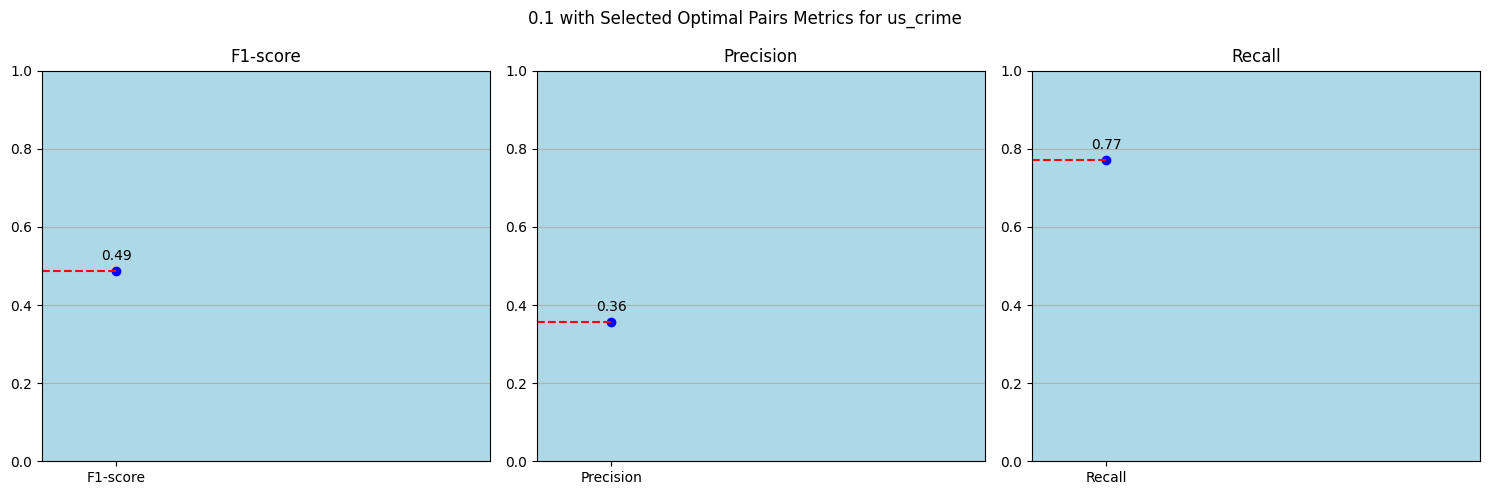

********************


Additional Feature pairs evaluation for libras_move, took 4.96 seconds.
Average time per feature pair: 0.0079 seconds.
Number of "selected optimal pairs" for libras_move: 126
Selected optimal pairs: [(27, 13), (27, 15), (27, 48), (61, 71), (48, 68), (74, 48), (27, 46), (48, 36), (71, 59), (71, 27), (57, 13), (85, 48), (27, 7), (48, 13), (83, 48), (71, 57), (75, 83), (24, 48), (59, 13), (48, 30), (45, 27), (34, 48), (59, 15), (57, 46), (12, 16), (45, 85), (59, 16), (46, 36), (46, 59), (46, 48), (46, 68), (53, 48), (57, 48), (49, 42), (24, 8), (71, 48), (48, 42), (24, 10), (48, 79), (61, 46), (48, 15), (61, 81), (61, 22), (55, 13), (48, 59), (57, 7), (45, 48), (34, 38), (49, 27), (36, 42), (81, 48), (61, 7), (27, 80), (22, 48), (12, 27), (32, 48), (75, 46), (48, 7), (61, 13), (45, 46), (46, 13), (75, 27), (27, 53), (32, 42), (38, 48), (75, 48), (45, 83), (75, 81), (8, 53), (24, 12), (12, 18), (34, 42), (80, 48), (85, 53), (61, 15), (59, 7), (59, 79), (27, 81), (32,

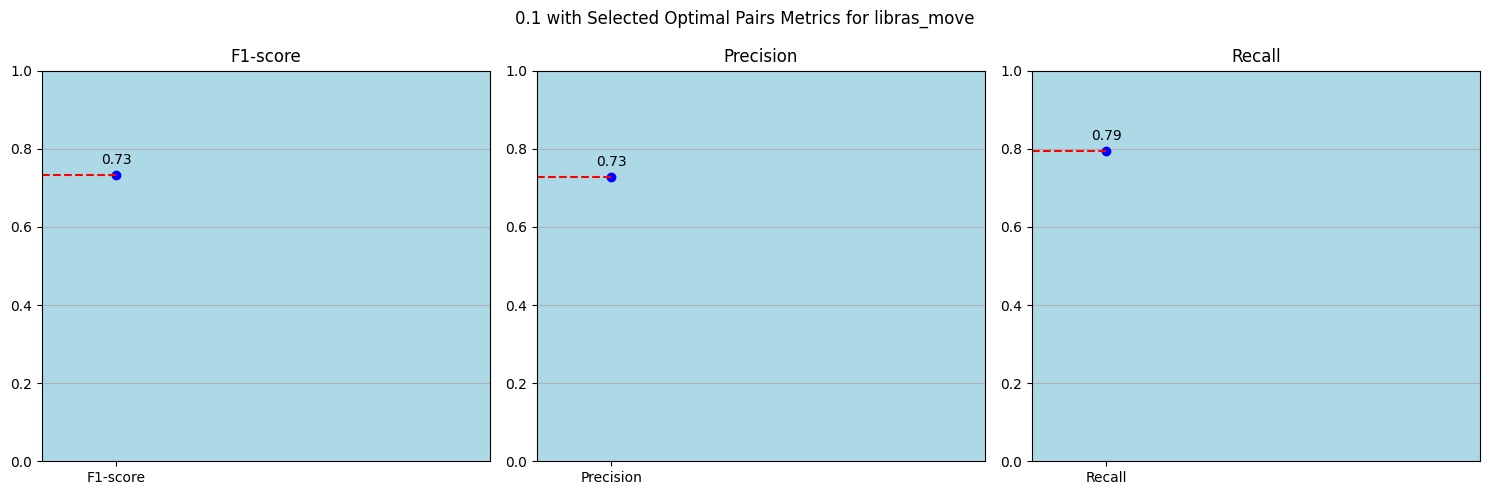

********************


Additional Feature pairs evaluation for letter_img, took 0.26 seconds.
Average time per feature pair: 0.0173 seconds.
Number of "selected optimal pairs" for letter_img: 3
Selected optimal pairs: [(14, 12), (14, 15), (14, 13)]
Number of 0.1 fraction features indices: 1
0.1 feature indices: [8]
Number of all features in "extended 0.1 with selected optimal pairs": 5
All features in "extended 0.1 with optimal pairs": [8, 12, 13, 14, 15]
New additional Features added to 0.1 of top features, becoming 0.3 fraction of all features in letter_img dataset.


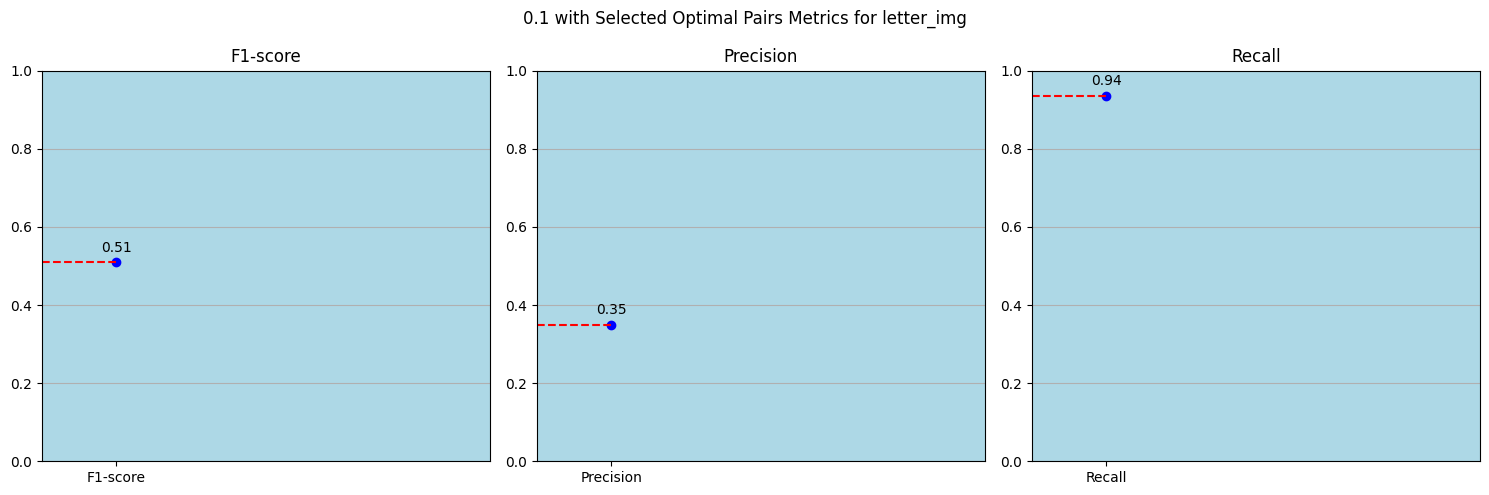

********************


Additional Feature pairs evaluation for mammography, took 0.01 seconds.
Average time per feature pair: 0.0078 seconds.
Number of "selected optimal pairs" for mammography: 1
Selected optimal pairs: [(2, 3)]
Number of 0.1 fraction features indices: 1
0.1 feature indices: [0]
Number of all features in "extended 0.1 with selected optimal pairs": 3
All features in "extended 0.1 with optimal pairs": [0, 2, 3]
New additional Features added to 0.1 of top features, becoming 0.6 fraction of all features in mammography dataset.


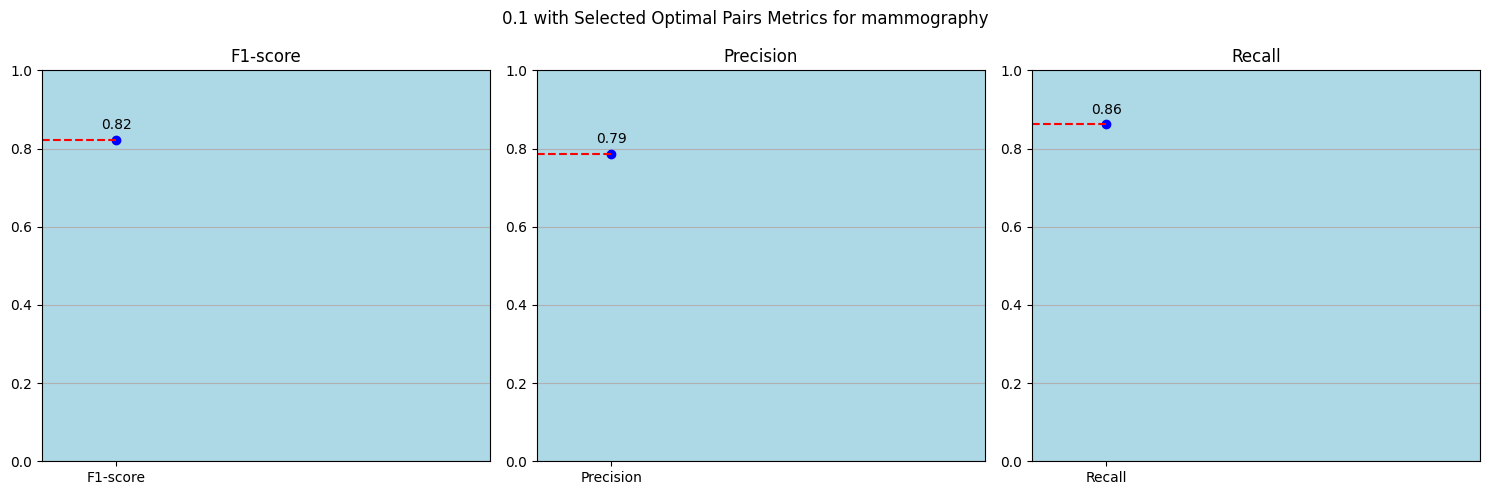

********************




In [9]:
extended_010_with_optimal_pairs_f1_scores= []
all_datasets_fraction_extended_010_with_optimal_pairs= [] # corresponding fractions of extended 0.1 with optimal pairs for all datasets

# Iterate over each dataset
for name, (X, y) in data_dict.items():

    X_imputed = np.where(X == '?', np.nan, X)  # Convert '?' to NaN
    # Impute missing values in X:
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X_imputed)
    X_imputed = pd.DataFrame(X_imputed, columns=X.columns)  # Convert to DataFrame

    # Scale the imputed data:
    X_scaled = scalers[name].fit_transform(X_imputed)
    X_scaled = pd.DataFrame(X_scaled, columns=X_imputed.columns)

    # Select Optimal Pairs (example: top 40%)
    select_pairs_percentage= 0.4
    num_additional_features = int(select_pairs_percentage * X_scaled.shape[1])
    # start_index = num_optimal_features_all_datasets[list(data_dict.keys()).index(name)] # after the last feature in optimal features set.
    start_index= max(1, int(0.1 * X_scaled.shape[1]))# start_index is 10% of the total number of features.
    # Calculate end_index and ensure it doesn't exceed the number of features
    end_index = min(start_index + num_additional_features, X_scaled.shape[1])

    feature_ranking = feature_ranking_all_datasets[list(data_dict.keys()).index(name)]
    additional_feature_indices = feature_ranking[start_index:end_index] # selecting pairs with choosing in the ranked features.

    pair_combinations = list(itertools.combinations(additional_feature_indices, 2)) # a list made of pair tuples. (additional_feature_indices must be at least 2.)

    if pair_combinations:  # Check if any pairs were evaluated

        num_splits = 5  # Set the number of splits
        pairs_features_f1_scores_all_splits = []  # To store F1-scores for all splits (of features in pairs)
        start_time= time.time()
        for _ in range(num_splits): # num_split times evaluating the pairs in pair_combinations.
            random_state = np.random.randint(100)
            pairs_features_f1_scores_single_split = {}  # To store F1-scores for a single split
            for pair in pair_combinations:
                feature1_index, feature2_index = pair
                X_pair = X_scaled.iloc[:, [feature1_index, feature2_index]]

                # Handle missing values (same as before)
                X_pair = np.where(X_pair == '?', np.nan, X_pair)
                imputer = SimpleImputer(strategy='median')
                X_pair = imputer.fit_transform(X_pair)

                X_train_pair, X_test_pair, y_train, y_test = train_test_split(X_pair, y, test_size=0.25, random_state=random_state)

                tree = DecisionTreeClassifier()
                tree.fit(X_train_pair, y_train)
                y_pred_pair = tree.predict(X_test_pair)

                f1 = f1_score(y_test, y_pred_pair, average='binary')
                pairs_features_f1_scores_single_split[pair] = f1

            pairs_features_f1_scores_all_splits.append(pairs_features_f1_scores_single_split)

        end_time = time.time()  # Record end time
        execution_time = end_time - start_time  # Calculate execution time

        print(f"Additional Feature pairs evaluation for {name}, took {execution_time/ num_splits:.2f} seconds.")  # Display all features evaluation execution time.
        print(f"Average time per feature pair: {(execution_time/ num_splits)/ len(pair_combinations):.4f} seconds.")  # Display average feature time.

        # Calculate Average F1-scores for Pairs
        pairs_features_f1_scores = {}
        for pair in pair_combinations:
            f1_scores_for_pair = [split_scores[pair] for split_scores in pairs_features_f1_scores_all_splits if pair in split_scores]
            if f1_scores_for_pair:  # Check if any scores were recorded for this pair
                pairs_features_f1_scores[pair] = np.mean(f1_scores_for_pair)
            else:
                pairs_features_f1_scores[pair] = 0.0  # Set to 0 if no scores were recorded

        # Now the average and more accurate F1-scores of pairs are calculated. (pairs_features_f1_scores dictionary)

        # Select Optimal Pairs (example: top 20% of pairs)
        select_optimal_pairs_percentage= select_pairs_percentage/ 2
        num_optimal_pairs = max(1, int(select_optimal_pairs_percentage * len(pairs_features_f1_scores)))
        optimal_pairs = sorted(pairs_features_f1_scores, key=pairs_features_f1_scores.get, reverse=True)[:num_optimal_pairs]
        # if name== 'us_crime':
        #   print(num_optimal_pairs)
        #   print(optimal_pairs)
        #   max_key = max(pairs_features_f1_scores, key=pairs_features_f1_scores.get)
        #   print(max_key, pairs_features_f1_scores[max_key])

        # optimal_feature_indices= feature_ranking[:start_index]
        _010_feature_indices= feature_ranking[:start_index]

        # Combine Features (previous optimal features with the new optimal pairs)
        extended_010_with_optimal_pairs_features = list(_010_feature_indices) # Start combining final features with features from 0.1 fraction
        for pair in optimal_pairs:
            feature1_index, feature2_index = pair
            extended_010_with_optimal_pairs_features.extend([feature1_index, feature2_index])  # Add features from optimal pairs

        # Remove duplicates
        extended_010_with_optimal_pairs_features = list(set(extended_010_with_optimal_pairs_features)) # if no feature is extended to the 0.1 fraction features, extended_010_with_optimal_pairs_features would be the same as list(_010_feature_indices).

        # Print statements
        print(f"Number of \"selected optimal pairs\" for {name}: {len(optimal_pairs)}")
        print(f"Selected optimal pairs: {optimal_pairs}")
        print(f"Number of 0.1 fraction features indices: {len(_010_feature_indices)}")
        print(f"0.1 feature indices: {_010_feature_indices}")
        print(f"Number of all features in \"extended 0.1 with selected optimal pairs\": {len(extended_010_with_optimal_pairs_features)}")
        print(f"All features in \"extended 0.1 with optimal pairs\": {extended_010_with_optimal_pairs_features}")


        # Training the SVM model (main model) with adding of optimal pairs:
        fraction_extended_010_with_optimal_pairs= round(len(extended_010_with_optimal_pairs_features) / X.shape[1], 1)
        print(f"New additional Features added to 0.1 of top features, becoming {fraction_extended_010_with_optimal_pairs} fraction of all features in {name} dataset.")
        all_datasets_fraction_extended_010_with_optimal_pairs.append(fraction_extended_010_with_optimal_pairs) # storing all correesponding fractions of datasets.

        # Extract Optimal Features from Dataset
        X_all_optimal = X_scaled.iloc[:, extended_010_with_optimal_pairs_features]

        # Convert '?' to NaN and Impute Missing Values
        X_all_optimal = np.where(X_all_optimal == '?', np.nan, X_all_optimal)
        imputer = SimpleImputer(strategy='median')
        X_all_optimal = imputer.fit_transform(X_all_optimal)

        # Training the main model in splits:
        num_splits = 5  # Set the number of splits
        results_all = []
        for _ in range(num_splits):
            random_state = np.random.randint(100)
            results = {'f1_score': [], 'precision': [], 'recall': []}

            # Train-Test Split
            X_train_optimal, X_test_optimal, y_train, y_test = train_test_split(
                X_all_optimal, y, test_size=0.25, random_state=random_state
            )

            # Standardize Features
            X_train_optimal = scalers[name].fit_transform(X_train_optimal)
            X_test_optimal = scalers[name].transform(X_test_optimal)

            # Train SVM Model
            svm = SVC(kernel='rbf', class_weight='balanced')
            svm.fit(X_train_optimal, y_train)

            # Evaluate Model
            y_pred = svm.predict(X_test_optimal)

            f1 = f1_score(y_test, y_pred, average='binary')
            precision = precision_score(y_test, y_pred, average='binary')
            recall = recall_score(y_test, y_pred, average='binary')

            results['f1_score'].append(f1)
            results['precision'].append(precision)
            results['recall'].append(recall)

            results_all.append(results)

        # Calculate average scores across splits
        f1_scores = [result['f1_score'][0] for result in results_all]
        precision_scores = [result['precision'][0] for result in results_all]
        recall_scores = [result['recall'][0] for result in results_all]

        avg_f1 = np.mean(f1_scores)
        avg_precision = np.mean(precision_scores)
        avg_recall = np.mean(recall_scores)

        extended_010_with_optimal_pairs_f1_scores.append(avg_f1)

        # Plotting the metrics results:
        metrics = ['F1-score', 'Precision', 'Recall']
        scores = [avg_f1, avg_precision, avg_recall]

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        for i, ax in enumerate(axs):
            ax.plot([metrics[i]], [scores[i]], marker='.', markersize=12, color='blue')
            ax.plot([-0.5, 0], [scores[i], scores[i]], color='red', linestyle='--')  # Add horizontal line
            ax.set_title(metrics[i])
            ax.set_ylim(0, 1)
            ax.set_xlim(-0.5, 2.5)  # Adjust x-axis limits to remove margins
            ax.set_facecolor('lightblue')  # Light blue background
            ax.grid(True, axis= 'y')

            # Add label above marker:
            ax.text(metrics[i], scores[i] + 0.02, f'{scores[i]:.2f}', ha='center', va='bottom')

        fig.suptitle(f'0.1 with Selected Optimal Pairs Metrics for {name}')
        plt.tight_layout()
        plt.show()

    else: # It depends on the recent pair selection process
        print(f"No pairs were evaluated for {name}.")
        print(f"Meaning that there is't any additional features to consider for pairs in {name} to be added to the top 0.1 fraction of features.")
        f1= _010_f1_scores[list(data_dict.keys()).index(name)] # f1-score is as same as 0.1 fraction of top features in the already trained SVM.
        extended_010_with_optimal_pairs_f1_scores.append(f1)

    print(20* "*")
    print("\n")


## **Summary Metric 2:**

In [ ]:
# plotting the results, f1-scores of:
# full set, 0.1, optimal, extended 0.1, corresponding fraction with 0.1, even any random fraction in corresponding with extended 0.1.


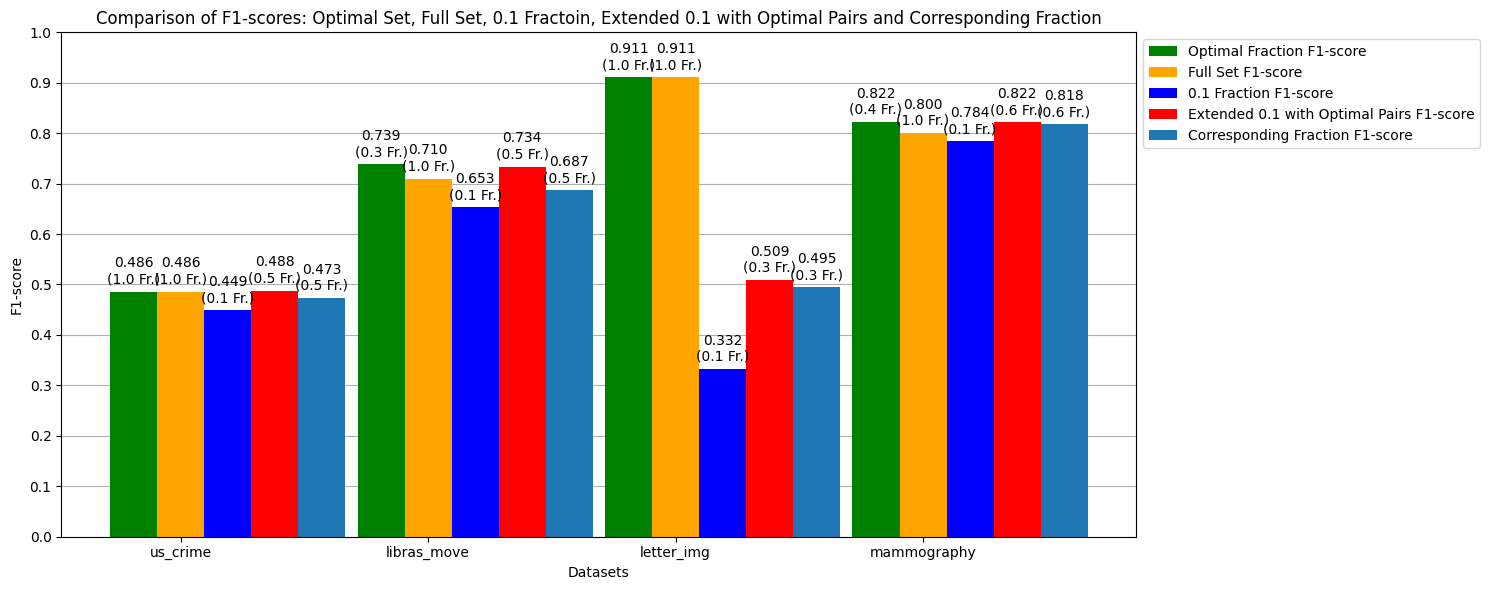

In [26]:
dataset_names = list(data_dict.keys())
bar_width = 0.19
index = np.arange(len(dataset_names))

plt.figure(figsize=(15, 6))
plt.bar(index, optimal_f1_scores, bar_width, label='Optimal Fraction F1-score', zorder= 2, color= 'green')
plt.bar(index + bar_width, full_set_f1_scores, bar_width, label='Full Set F1-score', zorder= 2, color= 'orange')
plt.bar(index + 2 * bar_width, _010_f1_scores, bar_width, label='0.1 Fraction F1-score', zorder= 2, color= 'blue')
plt.bar(index + 3 * bar_width, extended_010_with_optimal_pairs_f1_scores, bar_width, label='Extended 0.1 with Optimal Pairs F1-score', zorder= 2, color= 'red')
# Find corresponding fraction scores in all_datasets_all_fractions_f1_scores
corresponding_fraction_scores = []
for i, fraction in enumerate(all_datasets_fraction_extended_010_with_optimal_pairs):
    corresponding_index = fractions.index(fraction)
    corresponding_fraction_scores.append(all_datasets_all_fractions_f1_scores[i][corresponding_index])

plt.bar(index + 4 * bar_width, corresponding_fraction_scores, bar_width, label='Corresponding Fraction F1-score', zorder=2)

plt.xlabel('Datasets')
plt.ylabel('F1-score')
plt.title('Comparison of F1-scores: Optimal Set, Full Set, 0.1 Fractoin, Extended 0.1 with Optimal Pairs and Corresponding Fraction')
plt.xticks(index + (5 * bar_width / 5), dataset_names)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
plt.tight_layout()
for i in index:
  plt.text(index[i], optimal_f1_scores[i] + 0.01, f"{optimal_f1_scores[i]:.3f}\n({optimal_fractions[i]} Fr.)", ha='center', va='bottom')
  plt.text(index[i] + bar_width, full_set_f1_scores[i] + 0.01, f"{full_set_f1_scores[i]:.3f}\n(1.0 Fr.)", ha='center', va='bottom')
  plt.text(index[i] + 2 * bar_width, _010_f1_scores[i] + 0.01, f"{_010_f1_scores[i]:.3f}\n(0.1 Fr.)", ha='center', va='bottom')
  plt.text(index[i] + 3 * bar_width, extended_010_with_optimal_pairs_f1_scores[i] + 0.01, f"{extended_010_with_optimal_pairs_f1_scores[i]:.3f}\n({all_datasets_fraction_extended_010_with_optimal_pairs[i]} Fr.)", ha='center', va='bottom')
  plt.text(index[i] + 4 * bar_width, corresponding_fraction_scores[i] + 0.01, f"{corresponding_fraction_scores[i]:.3f}\n({fractions[all_datasets_all_fractions_f1_scores[i].index(corresponding_fraction_scores[i])]} Fr.)", ha='center', va='bottom')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, axis= 'y', zorder= 0)
plt.show()


In [ ]:
# each dataset, one plt for summary.
dataset_names = list(data_dict.keys())
bar_width = 0.19
index = np.arange(len(dataset_names))

for i, dataset_name in enumerate(dataset_names):
  plt.figure(figsize=(8, 6)) # Smaller figure size for individual plots

  optimal_f1 = optimal_f1_scores[i]
  optimal_fraction = optimal_fractions[i]
  full_set_f1 = full_set_f1_scores[i]
  _010_f1 = _010_f1_scores[i]
  extended_f1 = extended_010_with_optimal_pairs_f1_scores[i]
  extended_fraction = all_datasets_fraction_extended_010_with_optimal_pairs[i]
  corresponding_fraction = fractions[all_datasets_all_fractions_f1_scores[i].index(corresponding_fraction_scores[i])]
  corresponding_f1 = corresponding_fraction_scores[i]

  plt.bar(0, optimal_f1, bar_width, label='Optimal Fraction F1-score', zorder=2, color='green')
  plt.bar(1, full_set_f1, bar_width, label='Full Set F1-score', zorder=2, color='orange')
  plt.bar(2, _010_f1, bar_width, label='0.1 Fraction F1-score', zorder=2, color='blue')
  plt.bar(3, extended_f1, bar_width, label='Extended 0.1 with Optimal Pairs F1-score', zorder=2, color='red')
  plt.bar(4, corresponding_f1, bar_width, label='Corresponding Fraction F1-score', zorder=2)

  plt.xlabel('Metrics')
  plt.ylabel('F1-score')
  plt.title(f'Comparison of F1-scores for {dataset_name}')
  plt.xticks(index + (5 * bar_width / 5), ['Optimal', 'Full Set', '0.1', 'Extended 0.1', 'Corresponding'])
  plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
  plt.tight_layout()

  plt.text(0, optimal_f1 + 0.01, f"{optimal_f1:.3f}\n({optimal_fraction} Fr.)", ha='center', va='bottom')
  plt.text(1, full_set_f1 + 0.01, f"{full_set_f1:.3f}\n(1.0 Fr.)", ha='center', va='bottom')
  plt.text(2, _010_f1 + 0.01, f"{_010_f1:.3f}\n(0.1 Fr.)", ha='center', va='bottom')
  plt.text(3, extended_f1 + 0.01, f"{extended_f1:.3f}\n({extended_fraction} Fr.)", ha='center', va='bottom')
  plt.text(4, corresponding_f1 + 0.01, f"{corresponding_f1:.3f}\n({corresponding_fraction} Fr.)", ha='center', va='bottom')

  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.grid(True, axis='y', zorder=0)
  plt.show()